# PARCO for the HCVRP

Learning a Parallel AutoRegressive policy for a Combinatorial Optimization problem: the Heterogeneous Capacitated Vehicle Routing Problem (HCVRP).

<a href="https://colab.research.google.com/github/ai4co/parco/blob/main/examples/1.quickstart-hcvrp.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>  <a href="https://arxiv.org/abs/2409.0381"><img src="https://img.shields.io/badge/arXiv-2409.03811-b31b1b.svg" alt="Open In ArXiv"></a>


In [1]:
%load_ext autoreload
%autoreload 2

import torch
from rl4co.utils.trainer import RL4COTrainer

from parco.envs import HCVRPEnv
from parco.models import PARCORLModule, PARCOPolicy

# Greedy rollouts over trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/botu/miniforge3/envs/rl4co/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment

In [2]:
env = HCVRPEnv(generator_params=dict(num_loc=60, num_agents=5),
               data_dir="",
               val_file="../data/hcvrp/n60_m5_seed24610.npz",
               test_file="../data/hcvrp/n60_m5_seed24610.npz",
               )            
td_test_data = env.generator(batch_size=[3])
td_init = env.reset(td_test_data.clone()).to(device)
td_init_test = td_init.clone()

## Model

Here we declare our policy and our PARCO model (policy + environment + RL algorithm)

In [3]:
emb_dim = 128

# Policy is the neural network
policy = PARCOPolicy(env_name=env.name,
                    embed_dim=emb_dim,
                    agent_handler="highprob",
                    normalization="rms",
                    context_embedding_kwargs={
                        "normalization": "rms",
                        "norm_after": False,
                        }, # these kwargs go to the context embed (communication layers)
                    norm_after=False, # True means we use Kool structure
                   )

# We refer to the model as the policy + the environment + training data (i.e. full RL algorithm)
model = PARCORLModule(      env, 
                            policy=policy,
                            train_data_size=10_000,    # Small size for demo
                            val_data_size=1000,       # Small size for demo
                            batch_size=64,              # Small size for demo
                            num_augment=8,              # SymNCO augments to use as baseline
                            train_min_agents=5,         # Minmum number of agents to train on
                            train_max_agents=5,        # Maximum number of agents to train on
                            train_min_size=60,          # Minimum number of locations to train on
                            train_max_size=60,         # Maximum number of locations to train on 
                            optimizer_kwargs={'lr': 1e-4, 'weight_decay': 0}, # Here we have a higher learning rate for demo
)    # example, fewer epochs and simpler model for demo

/home/botu/miniforge3/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/botu/miniforge3/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### Test untrained model

Average tour length: 19.00
Tour 0 length: 11.80
Tour 1 length: 26.31
Tour 2 length: 18.89


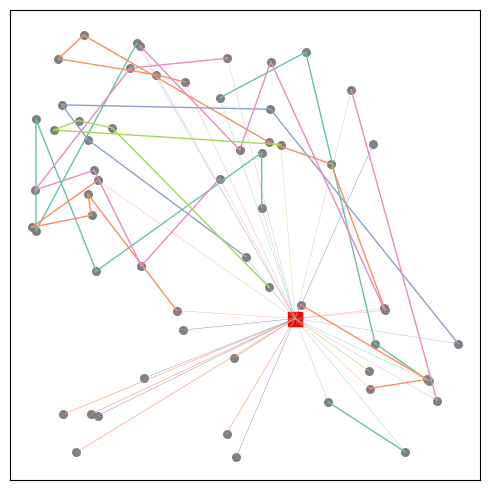

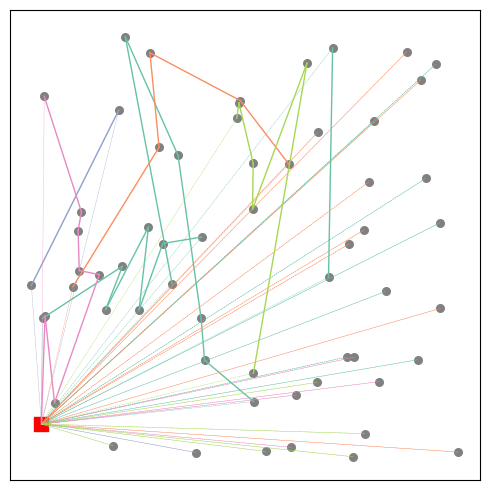

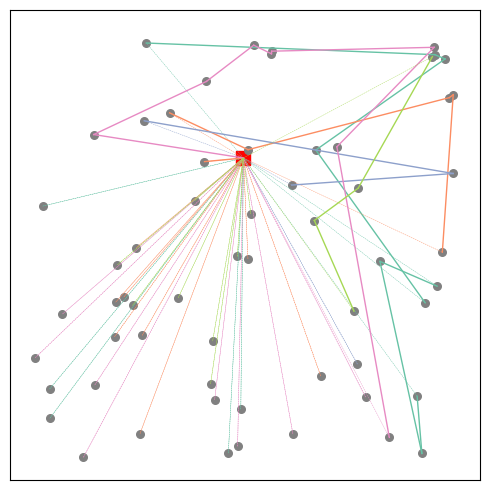

In [4]:
policy = model.policy.to(device)
out = policy(td_init_test.clone(), env, decode_type="greedy", return_actions=True)

# Plotting
actions = out["actions"]# .reshaape(td_init.shape[0], -1)
print("Average tour length: {:.2f}".format(-out['reward'].mean().item()))
for i in range(3):
    print(f"Tour {i} length: {-out['reward'][i].item():.2f}")
    env.render(td_init[i], actions[i].cpu(), plot_number=True)

## Training

In here we call the trainer and then fit the model

In [5]:
trainer = RL4COTrainer(
    max_epochs=5, # few epochs for demo
    accelerator="gpu", # change to cpu if you don't have a GPU (note: this will be slow!)
    devices=1, # change this to your GPU number
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/botu/miniforge3/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [6]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type        | Params
------------------------------------------------
0 | env             | HCVRPEnv    | 0     
1 | policy          | PARCOPolicy | 990 K 
2 | baseline        | NoBaseline  | 0     
3 | projection_head | MLP         | 33.0 K
------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.094     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/botu/miniforge3/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/botu/miniforge3/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 157/157 [01:16<00:00,  2.06it/s, v_num=3, train/reward=-5.71, train/loss=-0.272, val/reward=-5.77]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 157/157 [01:16<00:00,  2.06it/s, v_num=3, train/reward=-5.71, train/loss=-0.272, val/reward=-5.77]


## Evaluating the trained model

Now, we take the testing instances from above and evaluate the trained model on them with different evaluation techniques:
- Greedy: We take the action with the highest probability
- Sampling: We sample from the probability distribution N times and take the best one
- Augmentation: we first augment N times the state and then take the best action

### Greedy evaluation

Here we simply take the solution with greedy decoding type

Average tour length: 5.83
Tour 0 length: 6.75
Tour 1 length: 5.72
Tour 2 length: 5.03


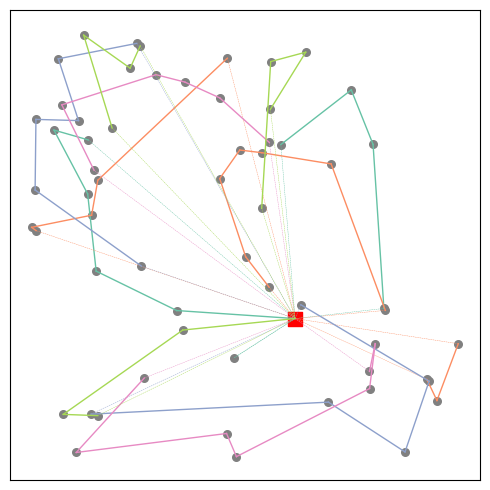

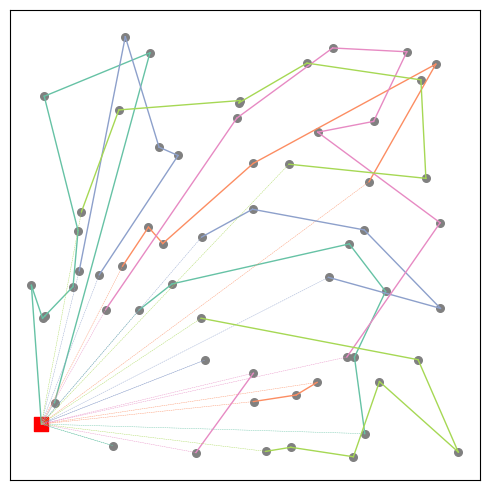

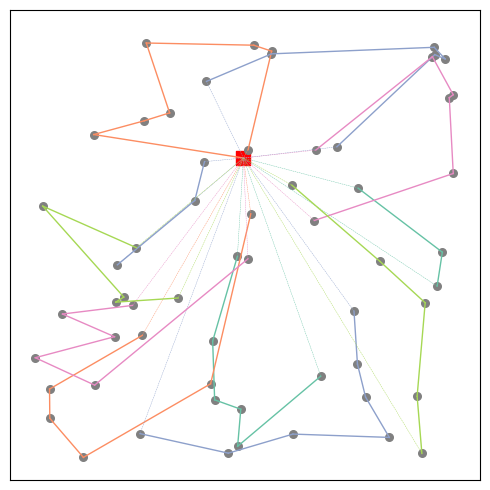

In [7]:
# Use same initial td as before
model = model.to(device)
out = model(td_init_test.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
actions =  out["actions"]#.reshape(td_init.shape[0], -1)
print("Average tour length: {:.2f}".format(-out['reward'].mean().item()))
for i in range(3):
    print(f"Tour {i} length: {-out['reward'][i].item():.2f}")
    env.render(td_init[i], actions[i].cpu(), plot_number=True)